## IMPORTS

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path
import uuid

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image
import torch.nn.functional as F

## Loading a image - some helpers

In [ ]:
imsize = (256, 256)
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  # adds another batch dimension
    return image

image = image_loader("dog.jpg")

A single batch of 256x256(width x height) image with 3 channels (R, G, B)

In [ ]:
image.size()

torch.Size([1, 3, 256, 256])

A custom edge detector, it contains 1 at the bottom and right and negative values in middle so it gives the edge

In [ ]:
edge_detector = torch.tensor([
                      [0.  , -5/3, 1],
                      [-5/3, -5/3, 1],
                      [1., 1., 1.]
                ])

expanding dimentions to fit the batch and channel size (3 channels and 1 batch)

In [ ]:
edge_detector_batch = edge_detector.expand(1, 3, 3, 3)/6

In [ ]:
edge_detector_batch.size()

torch.Size([1, 3, 3, 3])

## Using pytorch functional API to run our custom kernel

In [ ]:
out = F.conv2d(image, edge_detector_batch)

In [ ]:
out.size()

torch.Size([1, 1, 254, 254])

In [ ]:
out[0].size()

torch.Size([1, 254, 254])

In [ ]:
out_image = out[0].expand(3, 254, 254).permute(1, 2, 0).detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


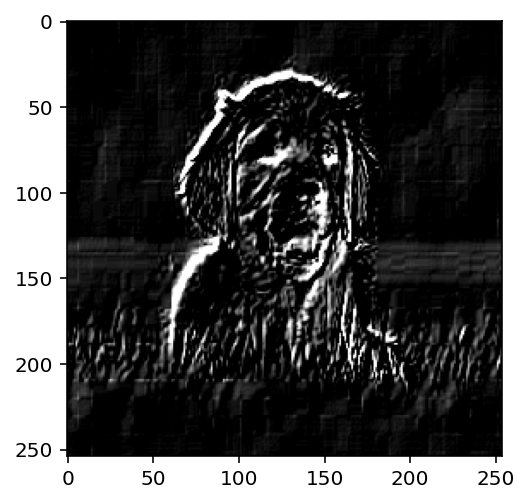

In [ ]:
plt.imshow(out_image, cmap="gray")

In [ ]:
inp_image = image[0].permute(1, 2, 0).detach().numpy()

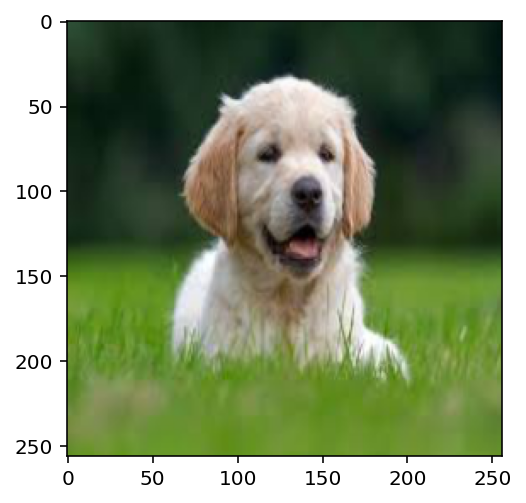

In [ ]:
plt.imshow(inp_image)

In [ ]:
image[0].size()

torch.Size([3, 256, 256])

In [ ]:
image = image_loader("dog.jpg")
image.size()

torch.Size([1, 3, 256, 256])

In [ ]:
resnet18 = models.resnet18(pretrained=True)
list(resnet18.children())

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        o = x.data.squeeze()
        return o

resnet18 = models.resnet18(pretrained=True)
fe = FeatureExtractor(resnet18)

features = fe(image)

In [ ]:
features.size()

torch.Size([512])

In [ ]:
image_dir = Path('images')
image_dir.mkdir(exist_ok=True, parents=True)

## Load some data for the reverse image search database

In [ ]:
import random
from bing_image_downloader import downloader
query_strings = ["dog", "cat", "boat", "human", "food", "fish", "house"]
for query_string in query_strings:
  print(f"[ INFO ] Downloading images for query string {query_string}")
  downloader.download(query_string, 
                      limit=random.choice([1, 2, 3]), 
                      output_dir=str(image_dir), 
                      adult_filter_off=True, 
                      force_replace=False, 
                      timeout=60)

In [ ]:
for image_path in image_dir.glob('**/*.jpg'):
    name = f'{str(uuid.uuid4())}.jpg'
    print(image_path)
    image_path.rename(image_dir/name)

In [ ]:
feature_dir = Path('features')
feature_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
for image_path in image_dir.glob('*.jpg'):
    print(image_path.stem)

In [ ]:
image_paths = list(image_dir.glob('*.jpg'))

## Extract features for our database

In [ ]:
for image_path in image_dir.glob('*.jpg'):
    image = image_loader(image_path)
    features = fe(image).detach().numpy()
    feature_path = feature_dir / f'{image_path.stem}.npy'
    np.save(feature_path, features)

In [ ]:
db_features = []
for image_path in image_dir.glob('*.jpg'):
    db_features.append(np.load(feature_dir/f'{image_path.stem}.npy'))

In [ ]:
db_features = np.array(db_features)

In [ ]:
db_features.shape, db_features[0].shape, len(image_paths)

((15, 512), (512,), 15)

## Lets query for an image

In [ ]:
query_image_path = 'human.jpg'
img = image_loader(query_image_path)
query_image = fe(img).detach().numpy()

In [ ]:
query_image.shape

(512,)

In [ ]:
dists = np.linalg.norm(db_features-query_image, axis=1)
id = np.argsort(dists)[:1]

In [ ]:
id

array([1])

In [ ]:
scores = [(dists[id], image_paths[id]) for id in ids]

In [ ]:
image_paths

[PosixPath('images/a4f3c668-2473-41e8-87c5-4e6dda6600c7.jpg'),
 PosixPath('images/b83e6e51-3f3a-46f0-be4f-00f192050d8c.jpg'),
 PosixPath('images/12fac6a3-5a63-4eb1-a65c-2c42fab7ac0a.jpg'),
 PosixPath('images/6dd970ac-76dc-4405-874c-8992c60eda3c.jpg'),
 PosixPath('images/44c3aba6-0660-4c81-8865-91f7737087bd.jpg'),
 PosixPath('images/ca6676c0-3c5a-486f-bfbf-0eabb4fab95a.jpg'),
 PosixPath('images/38ff5996-eaf8-420e-a5a5-9d9ed93e5879.jpg'),
 PosixPath('images/53de4abb-3cb7-4ee4-9d86-6f689d23aa66.jpg'),
 PosixPath('images/de608d4e-c486-4e8b-bd66-32547c249a7c.jpg'),
 PosixPath('images/b204f960-927e-4837-a1f2-770c69108d62.jpg'),
 PosixPath('images/69dd8013-8784-4550-a23f-a16e40ef144c.jpg'),
 PosixPath('images/8ab0c4c6-2dd2-4338-a41a-1b8cf80d8856.jpg'),
 PosixPath('images/a258fd99-12c3-4862-a6fb-97ee6acd1a99.jpg'),
 PosixPath('images/329c23d2-2ab8-485c-ab67-fcd62a0d2428.jpg'),
 PosixPath('images/c5c87234-a7ad-425b-a4c8-f3268c8d8e51.jpg')]

In [ ]:
scores

[(1.2632718, PosixPath('images/12fac6a3-5a63-4eb1-a65c-2c42fab7ac0a.jpg'))]

## Helpers to show the matched image

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import uuid

def show_image(file_name, shape=(64, 64)):
  img = cv2.imread(file_name)
  resized_img = cv2.resize(img, shape)
  print(f"[ INFO ] Shape of image before {img.shape}, resizing to {shape} \n")
  cv2_imshow(resized_img)

def save_image(link):
  name = str(uuid.uuid4())
  file_path = dataset_path/f'{name}.jpg'
  bu.save_image(link, file_path)
  return str(file_path)
  

[ INFO ] Shape of image before (225, 225, 3), resizing to (256, 256) 



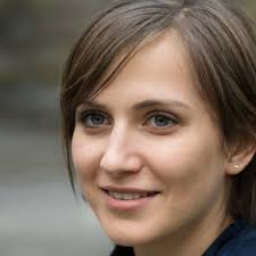

In [ ]:
show_image(query_image_path, shape=(256, 256))

[ INFO ] Shape of image before (1068, 987, 3), resizing to (256, 256) 



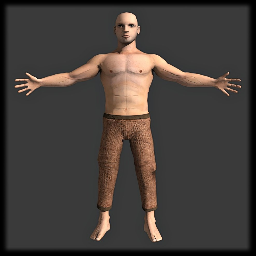

In [ ]:
show_image('images/a258fd99-12c3-4862-a6fb-97ee6acd1a99.jpg', shape=(256, 256))